In [1]:
import os
import re
import sys
import glob
import random
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
import ete3
from ete3 import PhyloTree
from Bio import SeqIO, AlignIO
from Bio import pairwise2, SeqRecord, Seq
from Bio.Data import CodonTable

import pymutspec
from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id, CodonAnnotation
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.io import GenesStates

In [9]:
path_to_tree = "../data/alisim/generations_sp/gtr_100_rnd_replica_0.full.treefile"
tree_without_outgrp = PhyloTree(path_to_tree, format=1)
tree_without_outgrp

PhyloTree node '198' (0x7f7d6bb356d)

In [10]:
tree_without_outgrp.describe()

Number of leaf nodes:	100
Total number of nodes:	198
Rooted:	No
Most distant node:	T86
Max. distance:	2.423299


In [11]:
tree_without_outgrp.children

[PhyloTree node '101' (0x7f7d6bb0767),
 PhyloTree node 'T1' (0x7f7d6bac4c7),
 PhyloTree node '193' (0x7f7d6bac4bb)]

In [12]:
def add_outgrp(tree: PhyloTree, factor=5, inplace=True):
    '''just change T1 node distance and rename it'''
    if not inplace:
        tree = tree.copy()
    leaves_dists = [x.dist for x in tree.iter_leaves()]
    d = sum(leaves_dists) / len(leaves_dists) * factor
    outgrp = tree.search_nodes(name="T1")[0]
    outgrp.dist = d
    outgrp.name = "OUTGRP"
    tree.set_outgroup("OUTGRP")
    
    tree.name = f"Node{tree.name}"
    for innode in tree.iter_descendants():
        if not innode.is_leaf() and len(innode.name) > 0:
            innode.name = f"Node{innode.name}"
    return tree


In [13]:
add_outgrp(tree_without_outgrp)

PhyloTree node 'Node198' (0x7f7d6bb356d)

In [19]:
tree_without_outgrp.write(format=1)

'(OUTGRP:0.24065,((((((((T5:0.167131,T40:0.0178787)Node107:0.0406341,((T38:0.0235105,T39:0.00716351)Node109:0.141819,(T12:0.132956,T13:0.0783158)Node110:0.301322)Node108:0.413623)Node106:0.0501215,((((((T22:0.193787,(T52:0.0178018,T53:0.123807)Node117:0.187955)Node116:0.106504,T15:0.103992)Node115:0.300575,T2:0.182295)Node114:0.0574962,(T7:0.103912,(T33:0.128729,T34:0.0702828)Node119:0.0154624)Node118:0.350121)Node113:0.0225279,(T8:0.151845,T9:0.0445424)Node120:0.254171)Node112:0.0614229,(T17:0.149296,(T48:0.0403426,T79:0.245544)Node122:0.0356078)Node121:0.0917715)Node111:0.165407)Node105:0.0877325,(((T87:0.1325,T88:0.0339397)Node125:0.0979212,((T83:0.0934804,T84:0.0274935)Node127:0.147738,T37:0.141245)Node126:0.283674)Node124:0.0471154,((T89:0.0346622,T90:0.22976)Node129:0.189745,T82:0.0353833)Node128:0.00661403)Node123:0.0850378)Node104:0.0202291,((T11:0.0388162,(T6:0.0164246,(((T18:0.061629,T26:0.0955099)Node135:0.293671,T16:0.0611944)Node134:0.00935213,(T27:0.00153434,T28:0.207734)

In [21]:
tree_without_outgrp.children

[PhyloTree node 'OUTGRP' (0x7f7d6bac4c7), PhyloTree node '' (0x7f7d6bb553a)]

In [22]:
tree_without_outgrp.describe()

Number of leaf nodes:	100
Total number of nodes:	199
Rooted:	Yes
Most distant node:	T86
Max. distance:	2.663949


In [44]:
tree_without_outgrp.write(outfile="../data/alisim/generations_test/bla.nwk", format=1)

In [31]:
o = tree_without_outgrp.children[1]
o.dist

0.5475441645399999

## Tests for GenomeState

In [2]:
pa = "../data/alisim/generations/gtr_100_rnd_replica_0.fa"

for x in SeqIO.parse(pa, "fasta"):
    print(x)
    print(len(x))
    break

ID: T13
Name: T13
Description: T13
Number of features: 0
Seq('CGTGCCTCAGTAGTCCGACAGGGGGGGCCCGAGAATGGTGAAACGGTGTGTGTG...AGC')
1000


In [3]:
gs = GenesStates([pa], states_fmt="fasta")

Ignore use_proba option and forcely set use_proba=False due to input alignment that doesn't contain probabilities
Genome states storage mode = 'dict'


In [6]:
for x in SeqIO.parse(pa, "fasta"):
    assert "".join(gs.get_genome(x.id)['1']) == x.seq, x

In [4]:
"".join(gs.get_genome("T13")['1'])[:50]

'CGTGCCTCAGTAGTCCGACAGGGGGGGCCCGAGAATGGTGAAACGGTGTG'

In [7]:
df = gs.read_alignment([pa])

In [9]:
assert "".join(df[df.Node == x.id].State.values) == x.seq

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198000 entries, 0 to 197999
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Node    198000 non-null  object
 1   Part    198000 non-null  object
 2   Site    198000 non-null  int64 
 3   State   198000 non-null  object
 4   p_A     198000 non-null  int64 
 5   p_C     198000 non-null  int64 
 6   p_G     198000 non-null  int64 
 7   p_T     198000 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 12.1+ MB


In [59]:
df

,Node,Part,Site,State,p_A,p_C,p_G,p_T
0,T13,1,1,C,0,1,0,0
1,T13,1,2,G,0,0,1,0
2,T13,1,3,T,0,0,0,1
3,T13,1,4,G,0,0,1,0
4,T13,1,5,C,0,1,0,0
...,...,...,...,...,...,...,...,...
197995,1000,1,996,T,0,0,0,1
197996,1000,1,997,A,1,0,0,0
197997,1000,1,998,T,0,0,0,1
197998,1000,1,999,T,0,0,0,1


In [52]:
gs.node2genome["T13"]

{'1': array(['C', 'G', 'G', 'C', 'A', 'G', 'T', 'A', 'C', 'G', 'A', 'G', 'G',
        'T', 'C', 'G', 'G', 'C', 'G', 'C', 'A', 'A', 'A', 'G', 'A', 'G',
        'A', 'T', 'G', 'G', 'G', 'G', 'A', 'A', 'G', 'G', 'G', 'T', 'G',
        'G', 'T', 'C', 'G', 'T', 'G', 'G', 'T', 'G', 'T', 'T', 'G', 'A',
        'T', 'G', 'T', 'A', 'G', 'C', 'G', 'G', 'T', 'C', 'C', 'C', 'G',
        'G', 'T', 'G', 'C', 'G', 'G', 'G', 'G', 'C', 'T', 'C', 'C', 'T',
        'A', 'G', 'G', 'G', 'G', 'T', 'G', 'G', 'T', 'G', 'A', 'T', 'A',
        'A', 'C', 'C', 'C', 'G', 'T', 'G', 'A', 'G', 'A', 'C', 'G', 'A',
        'T', 'A', 'A', 'G', 'G', 'G', 'G', 'C', 'G', 'A', 'G', 'C', 'C',
        'T', 'G', 'A', 'G', 'G', 'T', 'G', 'G', 'T', 'G', 'A', 'G', 'A',
        'G', 'G', 'C', 'G', 'G', 'G', 'T', 'G', 'G', 'G', 'G', 'T', 'G',
        'T', 'G', 'A', 'G', 'G', 'T', 'G', 'A', 'A', 'A', 'C', 'G', 'A',
        'G', 'G', 'A', 'G', 'T', 'A', 'T', 'C', 'C', 'G', 'A', 'C', 'G',
        'C', 'T', 'A', 'G', 'G', 'G', 'T', 'G'

In [37]:
df.head(10)

,Node,Part,Site,State,p_A,p_C,p_G,p_T
0,T13,1,1,C,0,1,0,0
1,T13,1,2,G,0,0,1,0
2,T13,1,3,T,0,0,0,1
3,T13,1,4,G,0,0,1,0
4,T13,1,5,C,0,1,0,0
5,T13,1,6,C,0,1,0,0
6,T13,1,7,T,0,0,0,1
7,T13,1,8,C,0,1,0,0
8,T13,1,9,A,1,0,0,0
9,T13,1,10,G,0,0,1,0


In [43]:
[random.lognormvariate(-2, 1) for _ in range(6)]

[0.20699004268831878,
 0.09331051025462418,
 0.15045942549968092,
 0.1956816650302434,
 0.07294324595246836,
 0.0385071328274652]

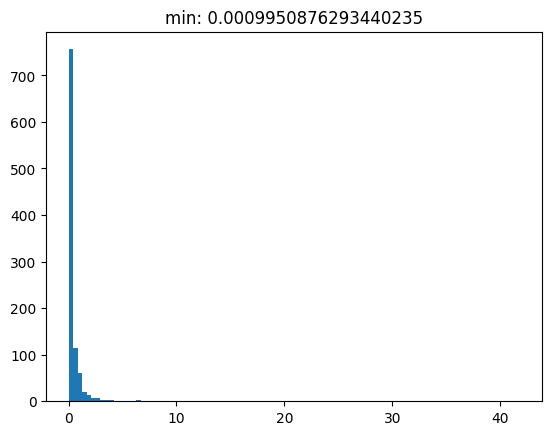

In [38]:
a = [random.lognormvariate(-2, 1.5) for _ in range(1000)]
plt.title(f"min: {min(a)}")
plt.hist(a, bins=100);

# Main

In [96]:
cytb_aln = [r for r in SeqIO.parse("../data/exposure/mammals/mulal/cytb_aln.fna", "fasta")]
nd1_aln  = [r for r in SeqIO.parse("../data/exposure/mammals/mulal/nd1_aln.fna", "fasta")]

In [70]:
cytb_pos_distro = [defaultdict(int) for _ in range(len(cytb_aln[0]))]
for rec in cytb_aln:
    for pos, nuc in enumerate(rec.seq):
        cytb_pos_distro[pos][nuc] += 1


nd1_pos_distro = [defaultdict(int) for _ in range(len(nd1_aln[0]))]
for rec in nd1_aln:
    for pos, nuc in enumerate(rec.seq):
        nd1_pos_distro[pos][nuc] += 1

In [76]:
df_cytb = pd.DataFrame(cytb_pos_distro).fillna(0)
df_nd1 = pd.DataFrame(nd1_pos_distro).fillna(0)[df_cytb.columns]

In [72]:
df_cytb.describe()

,-,!,A,T,G,C,R,N,Y
count,1371.000000,1371.000000,1371.000000,1371.000000,1371.000000,1371.000000,1371.000000,1371.000000,1371.000000
mean,221.673961,0.350839,330.325310,308.388767,142.015317,319.196207,0.011670,0.025529,0.012400
std,492.506368,8.445110,480.057523,463.566858,367.938515,448.452520,0.107436,0.157782,0.110702
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,49.000000,1.000000,16.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,660.500000,376.000000,47.000000,585.000000,0.000000,0.000000,0.000000
max,1321.000000,223.000000,1322.000000,1322.000000,1322.000000,1322.000000,1.000000,1.000000,1.000000


In [77]:
df_nd1.describe()

,-,!,A,T,G,C,R,N,Y
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.00000,1008.000000,1008.00000
mean,66.880952,1.490079,391.375992,355.398810,147.825397,360.927579,0.00496,0.091270,0.00496
std,289.396066,33.938432,495.413691,475.910304,369.487166,459.460936,0.07029,0.301606,0.07029
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
50%,0.000000,0.000000,40.500000,140.000000,4.000000,94.500000,0.00000,0.000000,0.00000
75%,0.000000,0.000000,823.500000,481.250000,59.000000,636.750000,0.00000,0.000000,0.00000
max,1323.000000,984.000000,1324.000000,1324.000000,1324.000000,1324.000000,1.00000,2.000000,1.00000


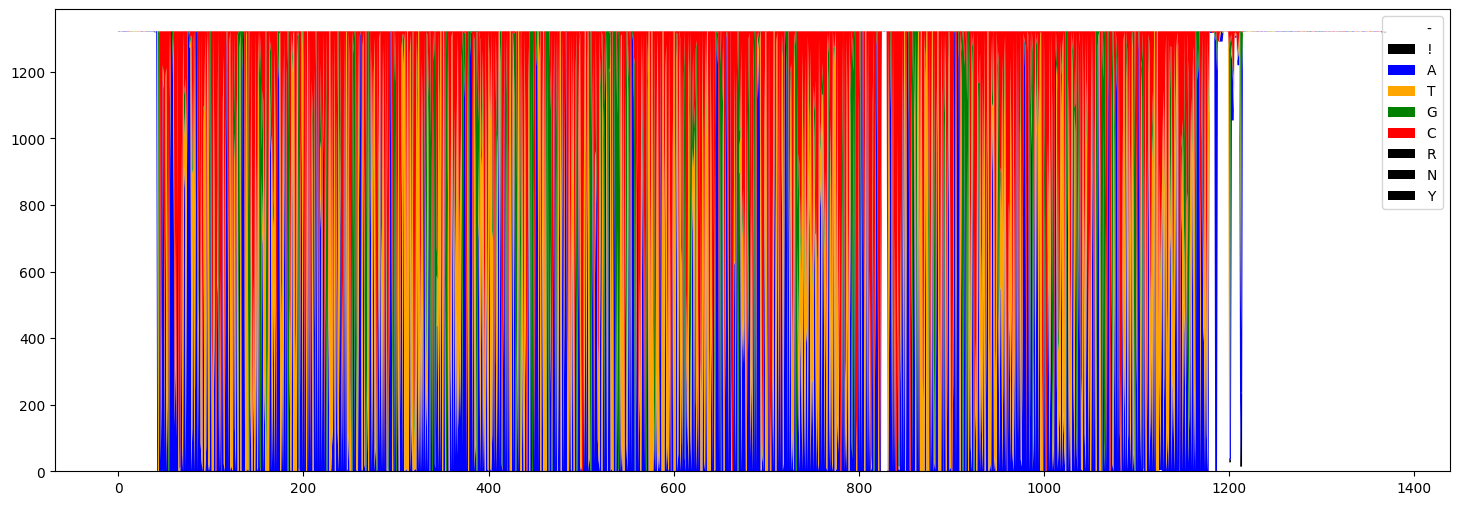

In [59]:
plt.figure(figsize=(18, 6))
plt.stackplot(df_cytb.index.values, [df_cytb[x].values for x in df_cytb.columns], labels=df_cytb.columns, colors=["w", "k", "b", "orange", "g", "r", "k", "k", "k"])
plt.legend();

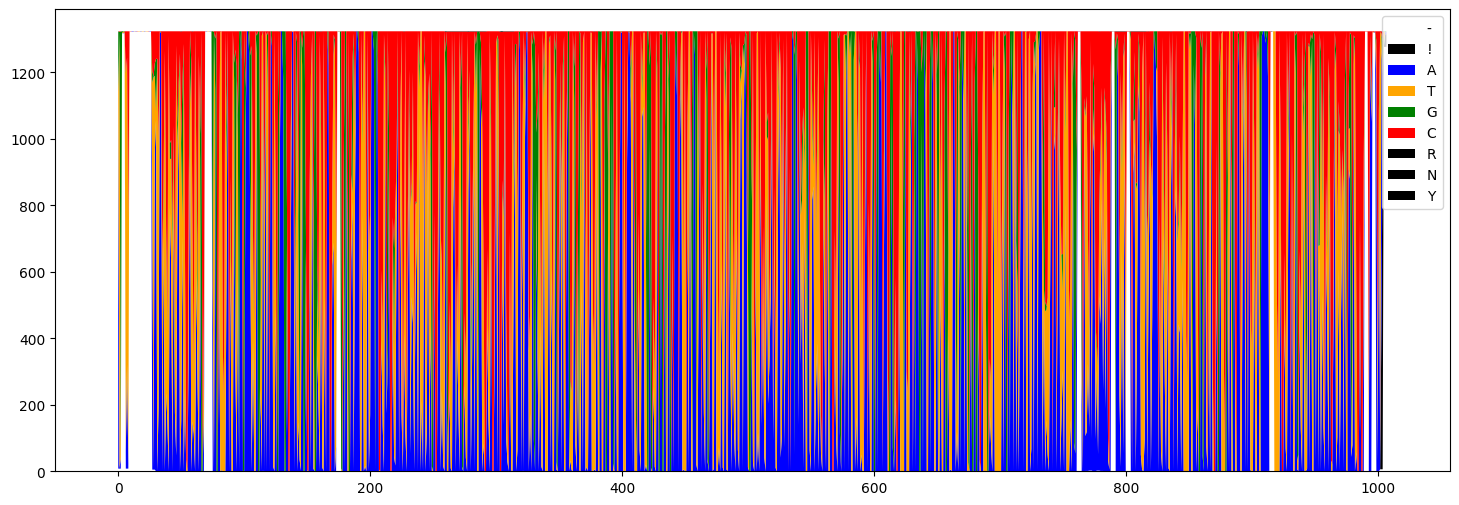

In [78]:
plt.figure(figsize=(18, 6))
plt.stackplot(df_nd1.index.values, [df_nd1[x].values for x in df_nd1.columns], labels=df_nd1.columns, colors=["w", "k", "b", "orange", "g", "r", "k", "k", "k"])
plt.legend();

In [79]:
df_cytb["Nuc"] = df_cytb[["A", "C", "G", "T"]].sum(axis=1)
df_cytb["NonNuc"] = df_cytb.drop(["A", "C", "G", "T", "Nuc"], axis=1).sum(axis=1)

df_nd1["Nuc"] = df_nd1[["A", "C", "G", "T"]].sum(axis=1)
df_nd1["NonNuc"] = df_nd1.drop(["A", "C", "G", "T", "Nuc"], axis=1).sum(axis=1)

In [81]:
(df_cytb.NonNuc == 0).value_counts()

True     1041
False     330
Name: NonNuc, dtype: int64

In [82]:
(df_nd1.NonNuc == 0).value_counts()

True     830
False    178
Name: NonNuc, dtype: int64

## Clean up headers

In [115]:
cytb_aln = [r for r in SeqIO.parse("../data/exposure/mammals/mulal/cytb_aln.fna", "fasta")]
nd1_aln  = [r for r in SeqIO.parse("../data/exposure/mammals/mulal/nd1_aln.fna", "fasta")]

In [116]:
sp_map = dict()
sp_map_rev = dict()
i = 1
for rec in cytb_aln:
    tmp = "RN_{}".format(i)
    header = rec.description
    if header == "Cociella_crocodila":
        idx = "OUTGRP"
    else:
        idx = sp_map_rev.get(header, tmp)
    
    sp_map[idx] = header
    sp_map_rev[header] = idx

    rec.id = idx
    rec.name = idx
    rec.description = idx
    i += 1

for rec in nd1_aln:
    tmp = "RN_{}".format(i)
    header = rec.description
    if header == "Cociella_crocodila":
        idx = "OUTGRP"
    else:
        idx = sp_map_rev.get(header, tmp)
    
    sp_map[idx] = header
    sp_map_rev[header] = idx

    rec.id = idx
    rec.name = idx
    rec.description = idx
    i += 1

In [117]:
len(sp_map), len(sp_map_rev), len(nd1_aln), len(cytb_aln)

(1324, 1324, 1324, 1322)

In [118]:
assert sp_map == {x:y for y,x in sp_map_rev.items()}
pd.Series(sp_map).to_csv("../data/exposure/mammals/names_map.txt", sep="\t", header=False)

SeqIO.write(nd1_aln, "../data/exposure/mammals/mulal/nd1_aln_coded.fna", "fasta-2line")
SeqIO.write(cytb_aln, "../data/exposure/mammals/mulal/cytb_aln_coded.fna", "fasta-2line")

1322